In [22]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# TO DO
# need to figure out how to ger around ema_a > ema_b on second time while rsi check is positive.
# dkng u path nvda arkg pltr ttd sofi ionq tsla googl celh arm rblx hcp ai joby

In [24]:
ticker = 'pltr'

In [25]:
# Fetch data for a ticker
# df_intra = yf.download(ticker, start='2024-06-01', end='2024-09-27', interval='60m')
df = yf.download(ticker, start='2024-01-01', end='2024-09-27')

[*********************100%%**********************]  1 of 1 completed


In [26]:
df.head(1)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-02,16.950001,16.950001,16.5,16.58,16.58,41626700


In [27]:
# Calculate moving averages 5|7 3|21 5|13
df['EMA_A'] = df['Close'].ewm(span=5, adjust=False).mean()
df['EMA_B'] = df['Close'].ewm(span=7, adjust=False).mean()

In [28]:
df.head(1)

,Open,High,Low,Close,Adj Close,Volume,EMA_A,EMA_B
Date,,,,,,,,
2024-01-02,16.950001,16.950001,16.5,16.58,16.58,41626700,16.58,16.58


In [29]:
# Calculate the RSI
delta = df['Close'].diff(1)

# # I replaced this with weighted avg vs rolling.
# gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
# loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
# rs = gain / loss
# rsi = 100 - (100 / (1 + rs))

# Calculate the exponentially weighted moving averages of gains and losses
gain_ewm = delta.where(delta > 0, 0).ewm(span=14, adjust=False).mean()
loss_ewm = -delta.where(delta < 0, 0).ewm(span=14, adjust=False).mean()

# Calculate the relative strength (RS)
rs = gain_ewm / loss_ewm

# Calculate the RSI
rsi = 100 - (100 / (1 + rs))




# Define the overbought and oversold levels (typically 70 and 30, respectively)
overbought_level = float(90.0)
oversold_level = float(10.0)

# Compute the median between overbought and oversold levels
median_rsi = np.median([overbought_level, oversold_level])

# Add the Median_RSI column indicating whether RSI is above or below the median
df['Median_RSI'] = np.where(rsi > median_rsi, 'above_median', 'below_median')

# add rsi column with rsi value
df['rsi'] = rsi

# ensure rsi is above median to be used in the crossed_above condition
rsi_check = df['rsi'] >= median_rsi

In [30]:
# Calculate MACD and signal line
def calculate_macd(df):
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

df['MACD'], df['Signal'] = calculate_macd(df)

In [31]:
# Identify when the 5-day EMA crosses above the 21-day EMA & rsi_check condition is met
crossed_above = (df['EMA_A'] > df['EMA_B']) & (df['EMA_A'].shift(1) < df['EMA_B'].shift(1)) & (rsi_check) 

# Identify when the 5-day EMA crosses above the 21-day EMA
# crossed_above = (df['EMA_A'] > df['EMA_B']) & (df['EMA_A'].shift(1) < df['EMA_B'].shift(1)) 

In [32]:
# # # Identify when the MACD line crosses below the signal line
# crossed_above = (df['MACD'] > df['Signal']) & (df['MACD'].shift(1) <= df['Signal'].shift(1))

In [33]:
df.loc[crossed_above, 'Cross_Direction'] = 'crossed up'

In [34]:
# Identify when the A-day EMA crosses below the B-Day EMA
crossed_below = (df['EMA_A'] < df['EMA_B']) & (df['EMA_A'].shift(1) > df['EMA_B'].shift(1))

df.loc[crossed_below, 'Cross_Direction'] = 'crossed down'

In [35]:
# # Identify when the A-day EMA crosses below the B-Day EMA
# crossed_below_ema = (df['EMA_A'] < df['EMA_B']) & (df['EMA_A'].shift(1) > df['EMA_B'].shift(1))

# # Identify when the MACD line crosses below the signal line
# crossed_below_macd = (df['MACD'] < df['Signal']) & (df['MACD'].shift(1) > df['Signal'].shift(1))

# # Combine both conditions using logical OR operator
# crossed_below = crossed_below_ema | crossed_below_macd

# # Update the 'Cross_Direction' column
# df.loc[crossed_below, 'Cross_Direction'] = 'crossed down'

In [36]:
# # Identify when the MACD line crosses below the signal line
# crossed_below = (df['MACD'] < df['Signal']) & (df['MACD'].shift(1) > df['Signal'].shift(1))

# # Update the 'Cross_Direction' column
# df.loc[crossed_below, 'Cross_Direction'] = 'crossed down'

In [37]:
# Filter for rows where the 5-day EMA crossed either above or below the 21-day EMA
condition_met = df[df['Cross_Direction'].notna()]

In [38]:
# Display the dates when the conditions were met and the direction of the crossover
print("\nDates when the conditions were met and cross direction:")
condition_met[['Close', 'EMA_A', 'EMA_B', 'Cross_Direction', 'Median_RSI', 'rsi']]


Dates when the conditions were met and cross direction:


,Close,EMA_A,EMA_B,Cross_Direction,Median_RSI,rsi
Date,,,,,,
2024-01-10,16.790001,16.518615,16.491077,crossed up,above_median,60.516499
2024-01-17,16.389999,16.529973,16.530849,crossed down,below_median,44.575804
2024-01-19,16.780001,16.584433,16.568602,crossed up,above_median,59.445756
2024-01-25,16.459999,16.790505,16.791315,crossed down,below_median,43.452517
2024-01-29,17.090000,16.792447,16.783240,crossed up,above_median,57.965553
2024-01-31,16.090000,16.546643,16.601823,crossed down,below_median,38.940440
2024-02-02,17.020000,16.656286,16.655400,crossed up,above_median,56.744706
2024-02-23,22.969999,23.420774,23.442291,crossed down,above_median,52.467602
2024-02-27,24.530001,23.821455,23.736289,crossed up,above_median,63.829966


In [39]:
df.head(1)

,Open,High,Low,Close,Adj Close,Volume,EMA_A,EMA_B,Median_RSI,rsi,MACD,Signal,Cross_Direction
Date,,,,,,,,,,,,,
2024-01-02,16.950001,16.950001,16.5,16.58,16.58,41626700,16.58,16.58,below_median,NaN,0.0,0.0,NaN


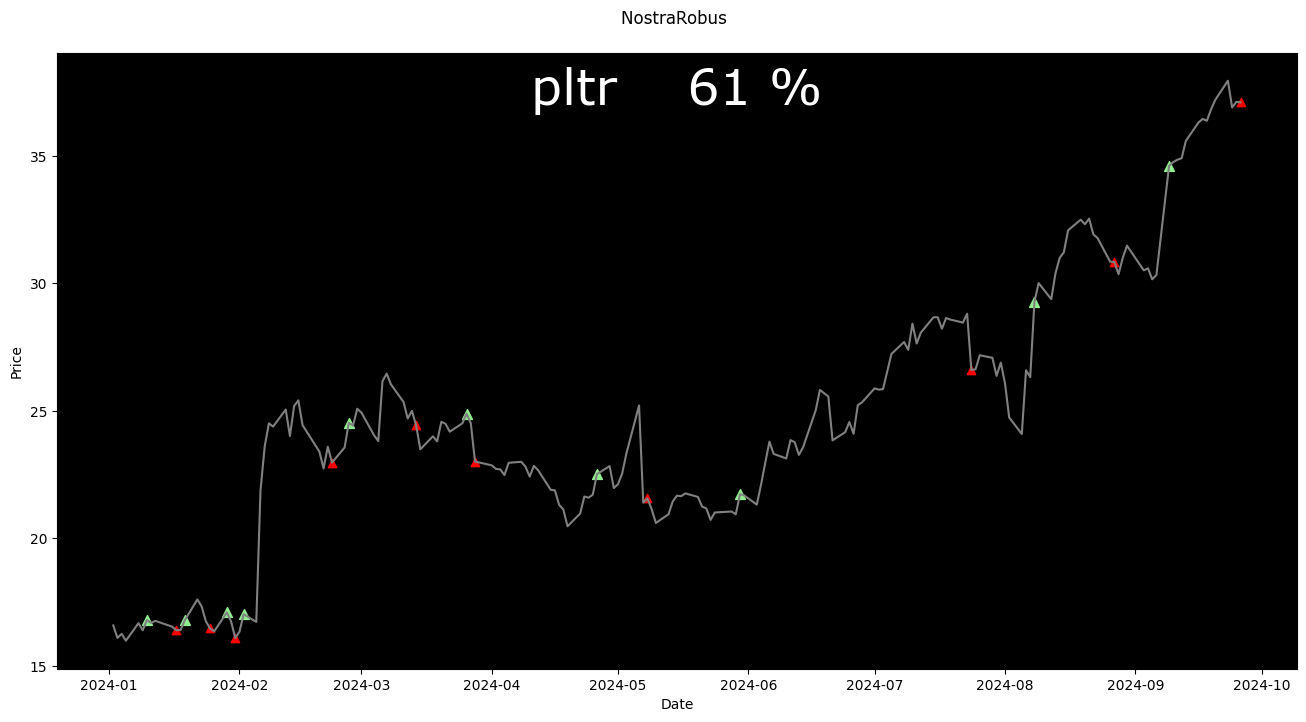

Results For Ticker:   pltr
Initial Investment:  16.790000915527344
Final Portfolio Value:  27
Profit/Loss:  10.2
Percent: 60.9%




,Action,Date,Open,Close,Price,Cash
0,Buy,2024-01-10,16.500000,16.790001,16.790001,0.000000
1,Sell,2024-01-17,16.260000,16.389999,16.260000,16.389999
2,Buy,2024-01-19,16.570000,16.780001,16.780001,-0.390001
3,Sell,2024-01-25,16.920000,16.459999,16.920000,16.069998
4,Buy,2024-01-29,16.450001,17.090000,17.090000,-1.020002
5,Sell,2024-01-31,16.410000,16.090000,16.410000,15.069998
6,Buy,2024-02-02,16.340000,17.020000,17.020000,-1.950003
7,Sell,2024-02-23,23.530001,22.969999,23.530001,21.019997
8,Buy,2024-02-27,23.760000,24.530001,24.530001,-3.510004
9,Sell,2024-03-14,24.830000,24.430000,24.830000,20.919996


In [40]:
# Initialize variables
init_cost = 1 # we need this set so when conditions are not met, we don't divide by 0
cash = init_cost  # Initial cash balance
shares_owned = 0
portfolio_value = cash
prev_crossed_above = False
rsi_above_median = False
transactions = []
last_trans = 'crossed down'
df.iloc[-1, df.columns.get_loc('Cross_Direction')] = last_trans

# Plot the line graph with arrows indicating the direction of crossover
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Close'], label='Close Price', color='gray')
plt.gca().set_facecolor('black')  # Set the background color to black


# Find the first crossed up event and set the initial cost
for index, row in df.iterrows():
    if row['Cross_Direction'] == 'crossed up':
        init_cost = row['Close']  # Set init_cost to the price at the first crossed up event
        cash = init_cost  # Set cash to the initial cost
        break

# Loop through the dataframe
for index, row in df.iterrows():
    if row['Cross_Direction'] == 'crossed up' and prev_crossed_above == False:  # Check if the Cross_Direction column is 'crossed up'
        # Buy one share
        # shares_owned += 1
        cash -= row['Close']  # Deduct purchase price from cash
        transactions.append(('Buy', index, row['Open'], row['Close'], row['Close'], cash))
        prev_crossed_above = True
        plt.scatter(index, row['Close'], marker='^', color='lightgreen', s=50, label='Crossed Up')
    elif row['Cross_Direction'] == 'crossed down' and prev_crossed_above:  # Check if the Cross_Direction column is 'crossed down':
        cash += row['Close'] #* shares_owned  # Add sale price to cash
        transactions.append(('Sell', index, row['Open'], row['Close'], row['Open'], cash))
        prev_crossed_above = False
        plt.scatter(index, row['Close'], marker='^', color='red', label='Crossed Down')
    else:
        pass
    
# Calculate final portfolio value
portfolio_value = cash

# Evaluate performance
initial_investment = init_cost # Initial cash investment
profit_loss = portfolio_value - initial_investment

percent = (profit_loss / initial_investment) * 100

# Add the ticker symbol and other things as labels
plt.text(0.5, 0.9, ticker + '    ' + str(round(percent)) + ' %', transform=plt.gca().transAxes, fontsize=36, verticalalignment='bottom', \
         horizontalalignment='center', fontname='MS Reference Sans Serif', fontweight='bold', color='white')
plt.title('NostraRobus \n', fontname='MS Reference Sans Serif', fontweight='bold', color='black')
plt.xlabel('Date', color='black')
plt.ylabel('Price', color='black')
plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='black')
plt.grid(False)
plt.show()



print('Results For Ticker:  ', ticker)
print('Initial Investment: ', initial_investment)
print("Final Portfolio Value: ", int(portfolio_value))
print("Profit/Loss: ", round(profit_loss,1))
print("Percent: {:.1f}%".format(percent))
print('\n')
transactions_df = pd.DataFrame(transactions, columns=['Action', 'Date', 'Open', 'Close', 'Price', 'Cash'])
transactions_df



In [41]:
# df.to_csv(r'C:\Users\rindel\Downloads\filename.csv', index=True)
# transactions_df.to_csv('filename.csv', index=True)


In [42]:
# # Inspect data for accuracy. Filter the DataFrame to include rows starting from a specific date
# specific_date = '2024-08-30'
# filtered_df = df.loc[specific_date:]
# specific_col = ['Open', 'Close', 'Cross_Direction', 'Median_RSI', 'EMA_A', 'EMA_B', 'rsi']
# filtered_df[specific_col].head(2)

,Open,Close,Cross_Direction,Median_RSI,EMA_A,EMA_B,rsi
Date,,,,,,,
2024-08-30,31.049999,31.48,NaN,above_median,31.158341,31.162946,59.392421
2024-09-03,31.350000,30.51,NaN,below_median,30.942227,30.999710,46.509411
